Init Pandas and parse tables from Wiki

In [5]:
import pandas as pd
import re

# Load all tables from the URL into a list
south_park_tables = pd.read_html(
      "https://en.wikipedia.org/wiki/List_of_South_Park_episodes"
)

Clean data

In [6]:
# Select and concatenate the specified tables
selected_tables = [south_park_tables[i] for i in range(1, 27)]
south_park_data = pd.concat(selected_tables).convert_dtypes()

# Rename columns if necessary
new_column_names = {
     "No. overall": "Number",
     "No. in season": "# in season",
}
data = south_park_data.rename(columns=new_column_names)

#Function to clean strings by removing text in brackets
def clean_string(s):
    if isinstance(s, str):
        return re.sub(r"\[.*?\]", "", s)
    else:
        return s
    
# Apply the cleaning function to each column in the DataFrame
for column in data.columns:
    data[column] = data[column].apply(clean_string)


# Find all columns that contain the phrase 
air_date_columns = [col for col in data.columns if "Original air date" in col or "Original release date" in col]
prod_code_columns = [col for col in data.columns if "Prod. code" in col or "Prod. code [399]" in col]
viewers_columns = [col for col in data.columns if "Viewers" in col or "viewers" in col]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 0 to 5
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Number                   321 non-null    int64 
 1   # in season              321 non-null    int64 
 2   Title                    321 non-null    object
 3   Directed by              321 non-null    object
 4   Written by               321 non-null    object
 5   Original air date [19]   13 non-null     object
 6   Prod. code               315 non-null    object
 7   U.S. viewers (millions)  261 non-null    object
 8   Original air date [44]   18 non-null     object
 9   Original air date [80]   17 non-null     object
 10  Original air date [111]  17 non-null     object
 11  Original air date [100]  14 non-null     object
 12  Original air date [157]  17 non-null     object
 13  Viewers (millions)       60 non-null     object
 14  Original air date [175]  15 non-null     object
 

Clean Air release date, Prod code and Viewers 

In [7]:
# Verify the identified columns
print("Identified air date columns:", air_date_columns)
print("Identified Prod. code columns:", prod_code_columns)
print("Identified viewers_columns columns:", viewers_columns)

# Combine these columns into a single column
# For each row, select the first non-null value from the original  columns
data['Air Date'] = data[air_date_columns].bfill(axis=1).iloc[:, 0]
data['Prod. Code'] = data[prod_code_columns].bfill(axis=1).iloc[:, 0]
data['Viewers (millions)'] = data[viewers_columns].bfill(axis=1).iloc[:, 0]

# Drop the original air date columns with footnote indicators
data = data.drop(columns=air_date_columns)
data = data.drop(columns=prod_code_columns)
data = data.drop(columns="U.S. viewers (millions)")

# Update the "Viewers (millions)" column
data = data.assign(
    **{
        "Viewers (millions)": lambda df: (
            df["Viewers (millions)"]
            .str.extract(r'(\d+\.\d+|\d+)')  # Extract the first number (float or integer)
            [0]  # Extract returns a DataFrame; select the first column
            .astype("Float64")  # Convert the column to Float64
        )
    }
)
# Display the updated DataFrame
print(data["Viewers (millions)"])

Identified air date columns: ['Original air date\u200a[19]', 'Original air date\u200a[44]', 'Original air date\u200a[80]', 'Original air date\u200a[111]', 'Original air date\u200a[100]', 'Original air date\u200a[157]', 'Original air date\u200a[175]', 'Original air date\u200a[191]', 'Original air date\u200a[206]', 'Original air date\u200a[221]', 'Original air date\u200a[236]', 'Original air date\u200a[247]', 'Original air date\u200a[257]', 'Original air date\u200a[270]', 'Original air date\u200a[285]', 'Original air date\u200a[300]', 'Original air date\u200a[315]', 'Original air date\u200a[326]', 'Original air date\u200a[337]', 'Original air date\u200a[348]', 'Original air date\u200a[359]', 'Original air date', 'Original release date']
Identified Prod. code columns: ['Prod. code', 'Prod. code\u200a[399]']
Identified viewers_columns columns: ['U.S. viewers (millions)', 'Viewers (millions)']
0    0.89
1    1.11
2    0.72
3    0.69
4    1.29
     ... 
1    0.56
2    0.48
3    0.47
4    0.4

Check Prod date

In [8]:
# Display the updated DataFrame for "Prod. code"
#print(data['Prod. code'])
print(data["Prod. Code"].sample(20))

5      606
8      909
4     2505
8     1509
6      307
5      906
13     214
8     2109
7     1108
8     1109
0     2201
8      609
6     1907
0     1601
1      803
1      603
7     1508
12     813
10    1011
6     1607
Name: Prod. Code, dtype: object


Convert column "Air Date" to date format

In [9]:
#Convert column "Air Date" to date format
data['Air Date'] = pd.to_datetime(data['Air Date'], errors='coerce')

# Verify the changes
print(data['Air Date'].head())


0   1997-08-13
1   1997-08-20
2   1997-08-27
3   1997-09-03
4   1997-09-10
Name: Air Date, dtype: datetime64[ns]


Convert all columns of type 'object' to 'string'

In [10]:
# Convert all columns of type 'object' to 'string'
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 321 entries, 0 to 5
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Number              321 non-null    int64         
 1   # in season         321 non-null    int64         
 2   Title               321 non-null    object        
 3   Directed by         321 non-null    object        
 4   Written by          321 non-null    object        
 5   Viewers (millions)  321 non-null    Float64       
 6   Air Date            321 non-null    datetime64[ns]
 7   Prod. Code          321 non-null    object        
dtypes: Float64(1), datetime64[ns](1), int64(2), object(4)
memory usage: 22.9+ KB


Check Directors data

In [11]:
data[[ "Directed by"]].describe()

,Directed by
count,321
unique,9
top,Trey Parker
freq,294


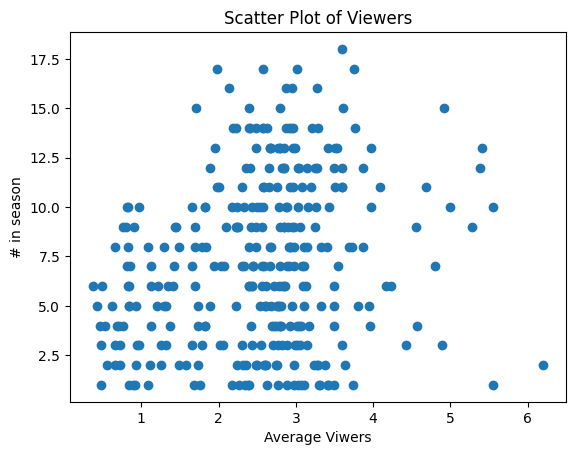

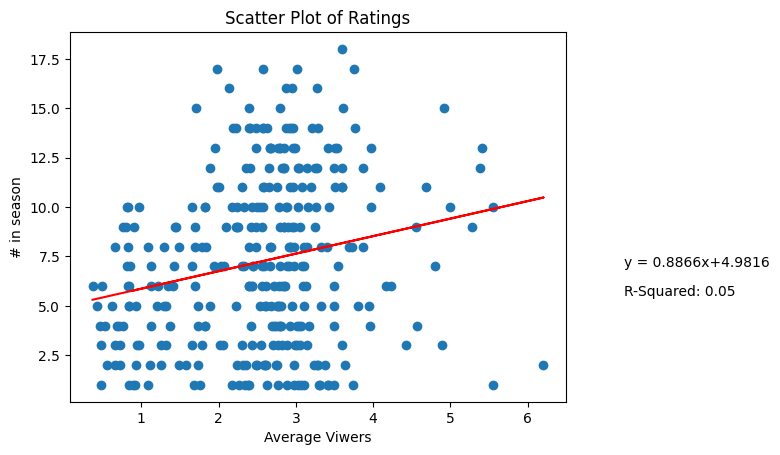

In [16]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(data["Viewers (millions)"], data["# in season"])
ax.set_title("Scatter Plot of Viewers")
ax.set_xlabel("Average Viwers")
ax.set_ylabel("# in season")
plt.show()

from sklearn.linear_model import LinearRegression
x = data.loc[:, ["Viewers (millions)"]]
y = data.loc[:, "# in season"]

model = LinearRegression()
model.fit(x, y)
r_squared = f"R-Squared: {model.score(x, y):.2f}"
best_fit = f"y = {model.coef_[0]:.4f}x{model.intercept_:+.4f}"
y_pred = model.predict(x)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.plot(x, y_pred, color="red")
ax.text(7.25, 5.5, r_squared, fontsize=10)
ax.text(7.25, 7, best_fit, fontsize=10)
ax.set_title("Scatter Plot of Ratings")
ax.set_xlabel("Average Viwers")
ax.set_ylabel("# in season")
plt.show()

Average viewers per season

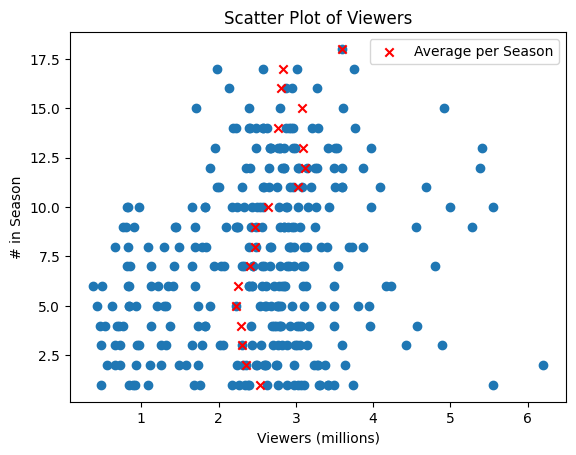

In [13]:
# Calculate average viewers per season
average_viewers_per_season = data.groupby('# in season')['Viewers (millions)'].mean()

# Create the scatter plot
fig, ax = plt.subplots()
ax.scatter(data["Viewers (millions)"], data["# in season"])

# Plot the average viewers per season
# Here, we use a different marker style for averages
ax.scatter(average_viewers_per_season, average_viewers_per_season.index, color='red', marker='x', label='Average per Season')

# Adding labels and title
ax.set_title("Scatter Plot of Viewers")
ax.set_xlabel("Viewers (millions)")
ax.set_ylabel("# in Season")

# Add a legend
ax.legend()